## 下ごしらえ

In [0]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
import time
import sys
# ライブラリまでのディレクトリ定義
#sys.path.append('../ml-scratch/utils') 
sys.path.append('../') # colaboratory用

import fc, get_mini_batch, relu, sgd, he_initializer, soft_max

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 前処理
X_train = X_train.astype(np.float)
X_train /= 255
X_train = X_train[:, np.newaxis, :, :]

# 学習データをスプリット
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape)

(48000, 1, 28, 28)


## 方針
- 一度ライブラリなど使って作りきってみる(im2col, col2im)  
→ 出力された値を正にして、どういった操作が必要になるかを後追いしたい

## 【問題1】2次元畳み込み層の作成


In [0]:
import numpy as np

class Conv2d:
    def __init__(self, W, b, optimizer, stride=1, pad=0):
        self.W = W
        self.b = b
        self.optimizer = optimizer
        self.stride = stride
        self.pad = pad
        self.x = None   
        self.col = None
        self.col_W = None
        self.dW = None
        self.db = None

        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = calc_conv_out_h(H, FH, self.stride, self.pad)
        out_w = calc_conv_out_w(W, FW, self.stride, self.pad)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        A = np.dot(col, col_W) + self.b
        A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return A

      
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.dW = np.dot(self.col.T, dout)

        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        self.db = np.sum(dout, axis=0)
        
        dcol = np.dot(dout, self.col_W.T)

        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        # self.W self.Bの更新
        self = self.optimizer.update(self)
        
        return dx

In [0]:
import numpy as np

class ConvSGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        layer.W -= self.lr * layer.dW                # 重さ更新

        layer.b -= self.lr * layer.db                   # バイアス更新
        
        return layer

In [0]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = calc_conv_out_h(H, filter_h, stride, pad)
    out_w = calc_conv_out_w(W, filter_w, stride, pad)

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    
    return col

  
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = calc_conv_out_h(H, filter_h, stride, pad)
    out_w = calc_conv_out_w(W, filter_w, stride, pad)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] = col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## 【問題2】2次元畳み込み後の出力サイズ
### (プーリング層後の出力サイズ)

In [0]:
def calc_conv_out_h(H, filter_h, stride, pad):
    return (H + 2*pad - filter_h)//stride + 1
    
    
def calc_conv_out_w(W, filter_w, stride, pad):
    return (W + 2*pad - filter_w)//stride + 1
  
  
def calc_pool_out_h(H, filter_h, stride, pad):
    return (H - filter_h + 2 * pad)//stride + 1
    
    
def calc_pool_out_w(W, filter_w, stride, pad):
    return (W - filter_w + 2 * pad)//stride + 1

In [22]:
print(calc_conv_out_h(28, 5, 1, 0))
print(calc_conv_out_h(28, 5, 1, 0))
print(calc_pool_out_h(28, 5, 2, 0))
print(calc_pool_out_w(28, 5, 2, 0))

24
24
12
12


In [23]:
tstX = X_train[:10]
print(tstX.shape)
W = np.random.randn(6, 1, 5, 5) 
b = np.zeros(6)
c2d = Conv2d(W, b, ConvSGD)
A1 = c2d.forward(tstX)
#print(A1)
print(A1.shape)

(10, 1, 28, 28)
(10, 6, 24, 24)


## 【問題3】最大プーリング層の作成

In [0]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

      
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [25]:
mp2d = MaxPool2D(2, 2, 2)
A2 = mp2d.forward(A1)
print(A2.shape)

W = np.random.randn(16, 6, 5, 5) 
b = np.zeros(16)
c2d = Conv2d(W, b, ConvSGD)
A3 = c2d.forward(A2)
#print(A3)
print(A3.shape)
mp2d = MaxPool2D(2, 2, 2)
A4 = mp2d.forward(A3)
#print(A4)
print(A4.shape)

(10, 6, 12, 12)
(10, 16, 8, 8)
(10, 16, 4, 4)


## 【問題4】平滑化

In [0]:
import numpy as np

class Flatten():
    def __init__(self):
        self.X = None
        self.S = None
        self.C = None
        self.H = None
        self.W = None
        
        
    def forward(self, X):
        self.S, self.C, self.H, self.W = X.shape     # shapeを記録
        self.X = X.reshape(self.S, -1)                    # 4d to 2d
        
        return self.X

      
    def backward(self, dout):
        return dout.reshape((self.S, self.C, self.H, self.W))

In [27]:
ft = Flatten()
A3 = ft.forward(A2)
print(A3.shape)

(10, 864)


## (重みの初期化)

In [0]:
import numpy as np

class ConvHeInitializer:
    """
    Heによる初期化
    """
    
    def W(self, FN, C, FH, FW):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        次の形のndarray, shape (n_nodes1, n_nodes2)
          重さ
        """
        

        return np.random.randn(FN, C, FH, FW) / np.sqrt(FN) * np.sqrt(2)
    
    
    def B(self, FN):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        次の形のndarray, shape (FN,)
          バイアス
        """
        
        return np.zeros(FN)
        

In [35]:
chi = ConvHeInitializer()
#print(chi.W(3, 1, 3, 3))
print(chi.W(3, 1, 3, 3).shape)

(3, 1, 3, 3)


In [0]:
import numpy as np
import logging                                                                     # ログ
from datetime import datetime                                        # 時間のやつ
from sklearn.preprocessing import OneHotEncoder       # ワンホットのやつ
from tqdm import tqdm                                                     # 進捗バーを出してくれるやつ


class Scratch2dCNNClassifier():
    """
    ニューラルネットワーク分類器
    """

    def __init__(self, batch_size=100, n_epochs=10,  n_nodes=[120, 84], 
                            n_convlayer=2, n_fclayer=3, verbose=True, sigma=1e-2, lr=1e-2, 
                            filter_n=[6, 16], filter_w=5, filter_h=5, stride=1, pad=0, pool_size=2, 
                            activation=None, optimizer='sgd'):

        self.batch_size = batch_size         # バッチサイズ
        self.n_epochs = n_epochs             # エポック数 
        self.n_nodes = n_nodes                 # ノード数
        self.n_convlayer = n_convlayer     # 畳み込み層の数
        self.n_fclayer = n_fclayer               # 全結合層の数
        self.verbose = verbose                    # 学習過程出力フラグ
        self.activation = activation             #活性化関数(文字列)
        self.filter_n = filter_n                      # フィルタ枚数
        self.filter_w = filter_w                     # フィルタwidth
        self.filter_h = filter_h                       # フィルタheight
        self.stride = stride                             # ストライド数
        self.pad = pad                                    # パディング数
        self.pool_size = pool_size                # プーリングサイズ
        self.conv_instances = []                  # 畳み込み層インスタンス格納用
        self.fc_instances = []                       # 全結合層インスタンス格納用
        self.conv_activations = []               # 畳み込み層活性化関数インスタンス格納用
        self.fc_activations = []                     # 全結合層活性化関数インスタンス格納用
        self.pool_instances = []                    # プーリング層インスタンス格納用
        self.loss_ = []                                     # 学習用データの学習過程格納用
        self.loss_val_ = []                              # 検証用データの学習過程格納用
        self.ft = Flatten()
        
        # 初期化・最適化クラスインスタンス作成
        if activation == 'relu':
            self.conv_initializer = ConvHeInitializer()
            self.fc_initializer = he_initializer.HeInitializer()
        else:
            # TODO:作ってないので割愛
            pass
        
        if optimizer == 'sgd':
            self.conv_optimizer = ConvSGD(lr)
            self.fc_optimizer = sgd.SGD(lr)
        elif optimizer == 'adagrad':
            # TODO:計算が遅くなるので割愛
            pass
            
        # ワンホットライブラリのインスタンス作成
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        
        # ログレベルを DEBUG に変更
        time_stamp = datetime.now().strftime('%Y%m%d')
        logging.basicConfig(filename='../tmp/sprint13_' + time_stamp + '.log', level=logging.DEBUG)
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # ワンホット化
        y = self.enc.fit_transform(y[:, np.newaxis])
        
        # 検証用データがある場合
        if X_val is not None:
            y_val= self.enc.fit_transform(y_val[:, np.newaxis])

        # 初期化
        N, C, H, W = X.shape
        n_output = y.shape[1]
        pool_out_h = H
        pool_out_w = W
        print()
        # Convインスタンス作成
        for i in range(self.n_convlayer):
            W = self.conv_initializer.W(self.filter_n[i], C, self.filter_h, self.filter_w)
            b = self.conv_initializer.B(self.filter_n[i])
            ins = Conv2d(W, b, self.conv_optimizer)

            # 活性化インスタンス
            if self.activation == 'sigmoid':
                act = sigmoid.Sigmoid()
            elif self.activation == 'tanh':
                act = tanh.Tanh()
            elif self.activation == 'relu':
                act = relu.ReLU()
                
            # プーリングインスタンス
            mp2d = MaxPool2D(self.pool_size, self.pool_size, self.pool_size)
            
            C = self.filter_n[i]
                
            self.conv_instances.append(ins)                           # 各自格納
            self.conv_activations.append(act)
            self.pool_instances.append(mp2d)
            
            # プーリング層出力サイズの計算
            pool_out_h = calc_pool_out_h(pool_out_h, self.filter_h, self.pool_size, self.pad)
            pool_out_w = calc_pool_out_w(pool_out_w, self.filter_w, self.pool_size, self.pad)
            
        n_features = self.filter_n[-1] * pool_out_h * pool_out_w
        
        # FCインスタンス作成
        for i in range(self.n_fclayer):
            if i == (self.n_fclayer - 1):     # 出力層
                ins = fc.FC(self.n_nodes[i - 1], n_output, self.fc_initializer, self.fc_optimizer)
                act = soft_max.Softmax()
            else:
                if i == 0:                       # 入力層
                    ins = fc.FC(n_features, self.n_nodes[i], self.fc_initializer, self.fc_optimizer)
                else:
                    ins = fc.FC(self.n_nodes[i - 1], self.n_nodes[i], self.fc_initializer, self.fc_optimizer)
                
                # 出力層以外は指定された活性化関数をインスタンス化
                if self.activation == 'sigmoid':
                    act = sigmoid.Sigmoid()
                elif self.activation == 'tanh':
                    act = tanh.Tanh()
                elif self.activation == 'relu':
                    act = relu.ReLU()
                
            self.fc_instances.append(ins)                           # 各自格納
            self.fc_activations.append(act)


        for e in tqdm(range(self.n_epochs)):
            # ミニバッチ化
            gmb = get_mini_batch.GetMiniBatch(X, y, batch_size=self.batch_size)
            # ロス格納用
            loss_ary = []
            
            # Xのn_samples / batch_size数分ループ処理
            for mini_X_train, mini_y_train in gmb:
                # forward propagation(ConV)
                for i in range(self.n_convlayer):
                    if i == 0:                              # 入力層
                        A = self.conv_instances[i].forward(mini_X_train)
                        Z = self.conv_activations[i].forward(A)
                        Z = self.pool_instances[i].forward(Z)
                    else:
                        A = self.conv_instances[i].forward(Z)
                        Z = self.conv_activations[i].forward(A)
                        Z = self.pool_instances[i].forward(Z)
                
                # reshape(4d to 2d)
                Z = self.ft.forward(Z)
                
                # forward propagation(FC)
                for i in range(self.n_fclayer):
                    A = self.fc_instances[i].forward(Z)
                    Z = self.fc_activations[i].forward(A)
                
                # backward propagation(FC)
                for i in range(self.n_fclayer):
                    n_FC = self.n_fclayer - i - 1      # インスタンス逆指定用
                    if i == 0:                               # 出力層
                        dA, loss = self.fc_activations[n_FC].backward(Z, mini_y_train)
                        loss_ary.append(loss)
                    else:                                     # 入力層
                        dA = self.fc_activations[n_FC].backward(dZ)
                        
                    dZ = self.fc_instances[n_FC].backward(dA)
                
                # reshape(2d to 4d)
                dZ = self.ft.backward(dZ)
                
                # backward propagation(conv)
                for i in range(self.n_convlayer):
                    n_conv = self.n_convlayer - i - 1      # インスタンス逆指定用
                    dA = self.pool_instances[n_conv].backward(dZ)
                    dA = self.conv_activations[n_conv].backward(dA)
                    dZ = self.conv_instances[n_conv].backward(dA)

                    
            #誤差を格納
            self.loss_.append(np.mean(loss_ary))
                        
            # 検証用データがある場合
            if X_val is not None:
                # forward propagation(ConV)
                for i in range(self.n_convlayer):
                    if i == 0:                              # 入力層
                        A = self.conv_instances[i].forward(X_val)
                        Z = self.conv_activations[i].forward(A)
                        Z = self.pool_instances[i].forward(Z)
                    else:
                        A = self.conv_instances[i].forward(Z)
                        Z = self.conv_activations[i].forward(A)
                        Z = self.pool_instances[i].forward(Z)
                
                # reshape(4d to 2d)
                Z = self.ft.forward(Z)
                
                # forward propagation(FC)
                for i in range(self.n_fclayer):
                    A = self.fc_instances[i].forward(Z)
                    Z = self.fc_activations[i].forward(A)
                
                dA, loss_val = self.fc_activations[self.n_fclayer - 1].backward(Z, y_val)

                #誤差を格納
                self.loss_val_.append(np.mean(loss_val))
                            

            # フラグがTrueであればログ出力
            if self.verbose:
                logging.info('forward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(A), A.shape)
                logging.info('forward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(Z), Z.shape)
                logging.info('backward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(dA), dA.shape)
                logging.info('backward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(dZ), dZ.shape)
                logging.info('loss %sエポック目 : %s', e+1, np.sum(loss))

        return self


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        
        # forward propagation(ConV)
        for i in range(self.n_convlayer):
            if i == 0:                              # 入力層
                A = self.conv_instances[i].forward(X)
                Z = self.conv_activations[i].forward(A)
                Z = self.pool_instances[i].forward(Z)
            else:
                A = self.conv_instances[i].forward(Z)
                Z = self.conv_activations[i].forward(A)
                Z = self.pool_instances[i].forward(Z)

        # reshape(4d to 2d)
        Z = self.ft.forward(Z)

        # forward propagation(FC)
        for i in range(self.n_fclayer):
            A = self.fc_instances[i].forward(Z)
            Z = self.fc_activations[i].forward(A)
        
        # 一番確率が高いラベルを予測値に
        y_pred = np.argmax(Z, axis=1)
        
        return y_pred

## 【問題5】学習・推定
## 【問題6】（アドバンス課題）LeNet

In [31]:
sdnnc= Scratch2dCNNClassifier(activation='relu')

sdnnc.fit(X_train, y_train, X_val, y_val)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [08:42<00:00, 52.03s/it]


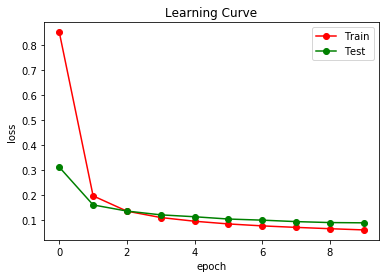

In [32]:
train_loss = np.array(sdnnc.loss_)
test_loss = np.array(sdnnc.loss_val_)

plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(train_loss, 'o-', color="r", label="Train")
plt.plot(test_loss, 'o-', color="g", label="Test")

plt.legend(loc=1)
plt.show()

In [33]:
# 予測
y_pred = sdnnc.predict(X_val)

print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

[[1164    0    5    1    0    0    6    1    1    3]
 [   1 1314    3    2    1    0    0    4    4    3]
 [   0    1 1167    4    2    0    1    7    4    3]
 [   1    1    9 1252    0    5    0    8    5    7]
 [   1    1    5    0 1126    0    4    3    3   19]
 [   1    1    3    4    0 1022   12    0   11    5]
 [   3    4    2    0    1    4 1199    0    7    0]
 [   0    3    9    1    4    0    0 1191    1    6]
 [   0    3    7    7    0   14    8    6 1114    6]
 [   4    1    0    1    3    3    0    9    6 1162]]
0.9759166666666667


## 【問題9】出力サイズとパラメータ数の計算

In [34]:
# intにはしない
def calc_pool_out_h(H, filter_h, stride, pad):
    return (H - filter_h + 2 * pad)/stride + 1
    
    
def calc_pool_out_w(W, filter_w, stride, pad):
    return (W - filter_w + 2 * pad)/stride + 1
  
# case1
# 入力サイズ : 144×144, 3チャンネル
in_width = 144
in_height = 144
in_ch = 3

# フィルタサイズ : 3×3, 6チャンネル
f_width = 3
f_height = 3
f_ch = 6

# ストライド : 1  パディング : なし
stride = 1
pad = 0

# 出力サイズ
out_height = calc_pool_out_h(in_height, f_height, stride, pad)
out_width = calc_pool_out_w(in_width, f_width, stride, pad)
out_ch = f_ch / in_ch
# パラメータ数 フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(出力1チャンネルごとに1つ)
n_params = f_width * f_height * in_ch * out_ch + out_ch
print('case1  size : H {} x W {} x CH {}  n_params : {}'.format(out_height, out_width, out_ch, n_params))


# case2
# 入力サイズ : 60×60, 24チャンネル
in_width = 60
in_height = 60
in_ch = 24

# フィルタサイズ : 3×3, 48チャンネル
f_width = 3
f_height = 3
f_ch = 48

# ストライド : 1  パディング : なし
stride = 1
pad = 0

# 出力サイズ
out_height = calc_pool_out_h(in_height, f_height, stride, pad)
out_width = calc_pool_out_w(in_width, f_width, stride, pad)
out_ch = f_ch / in_ch
# パラメータ数 フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(出力1チャンネルごとに1つ)
n_params = f_width * f_height * in_ch * out_ch + out_ch
print('case2  size : H {} x W {} x CH {}  n_params : {}'.format(out_height, out_width, out_ch, n_params))


# case3
# 入力サイズ : 20×20, 10チャンネル
in_width = 20
in_height = 20
in_ch = 10

# フィルタサイズ : 3×3, 20チャンネル
f_width = 3
f_height = 3
f_ch = 20

# ストライド : 2  パディング : なし
stride = 2
pad = 0

# 出力サイズ
out_height = calc_pool_out_h(in_height, f_height, stride, pad)
out_width = calc_pool_out_w(in_width, f_width, stride, pad)
out_ch = f_ch / in_ch
# パラメータ数 フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(出力1チャンネルごとに1つ)
n_params = f_width * f_height * in_ch * out_ch + out_ch
print('case3  size : H {} x W {} x CH {}  n_params : {}'.format(out_height, out_width, out_ch, n_params))

case1  size : H 142.0 x W 142.0 x CH 2.0  n_params : 56.0
case2  size : H 58.0 x W 58.0 x CH 2.0  n_params : 434.0
case3  size : H 9.5 x W 9.5 x CH 2.0  n_params : 182.0


3番目は出力サイズが小数点=余ったピクセルを見ないという処理が行われる  
===提出用ここまで===

各種関数の理解
- Conv2d.forward()・im2col

In [0]:
def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = calc_conv_out_h(H, FH, self.stride, self.pad)
    out_w = calc_conv_out_w(W, FW, self.stride, self.pad)

    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = self.W.reshape(FN, -1).T

    A = np.dot(col, col_W) + self.b
    A = A.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    self.x = x
    self.col = col
    self.col_W = col_W

    return A
      
    
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = calc_conv_out_h(H, filter_h, stride, pad)
    out_w = calc_conv_out_w(W, filter_w, stride, pad)

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    
    return col